# Les réseaux convolutionnels

Réseau inspiré de http://yann.lecun.com/exdb/publis/pdf/lecun-98.pdf

## 1. Importation des librairies

In [1]:
import os
import torch
from torch import nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import datasets
from torchvision import transforms

import matplotlib.pyplot as plt
import numpy as np

## 2. Chargement et conditionnement des données d'apprentissage

Chargement et normalisation des données

In [2]:
transform = transforms.Compose([
    transforms.Pad(2),         # Ajoute 2 pixels de padding sur chaque bord
    transforms.ToTensor()
])

training_dataset = datasets.MNIST(root="data", train=True, download=True, transform=transform)
test_dataset = datasets.MNIST(root="data", train=False, download=True, transform=transform)

La convention pour les images en entrée dans les réseaux de neurones convolutifs en PyTorch est d'utiliser des tenseurs de taille `(batch_size, channels, height, width)`. 

- `batch_size` correspond au nombre d'images dans un batch
- `channels` correspond au nombre de canaux de couleur de l'image. Pour une image en niveaux de gris, `channels` est égal à 1. Pour une image en couleur, `channels` est égal à 3 (rouge, vert, bleu)
- `height` correspond à la hauteur de l'image
- `width` correspond à la largeur 

## 3. Architecture du réseau 

Concevoir un réseau inspiré LeNet5 http://yann.lecun.com/exdb/publis/pdf/lecun-98.pdf
![LeNet5](https://miro.medium.com/max/2000/1*1TI1aGBZ4dybR6__DI9dzA.png)


La structure globale sera conservée (nombre de couches, nombre de neurones par couche…) mais dans cette version :
- Les couches de convolution sont totalement connectées
- La sortie est une couche fully connected (FC) classique 
- La fonction de coût est l’entropie croisée


Vous utiliserez la `nn.Sequential` pour le backbone et vous ajouterez une dernière couche pour la partie classlification

In [3]:
class MNISTModel(nn.Module):
    def __init__(self):
        super(MNISTModel, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=6, kernel_size=5, stride=1, padding=0)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2, padding=0)
        self.conv2 = nn.Conv2d(in_channels=6, out_channels=16, kernel_size=5, stride=1, padding=0)
        self.conv3 = nn.Conv2d(in_channels=16, out_channels=120, kernel_size=5, stride=1, padding=0)
        self.fc1 = nn.Linear(in_features=120 * 1 * 1, out_features=84)
        self.fc2 = nn.Linear(in_features=84, out_features=10)
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(p=0.25)

    def forward(self, x):
        #print('Input:', x.shape[1:])
        x = self.relu(self.conv1(x))
        #print('Après conv1:', x.shape[1:])
        x = self.pool(x)
        #print('Après pool1:', x.shape[1:])
        x = self.relu(self.conv2(x))
        #print('Après conv2:', x.shape[1:])
        x = self.pool(x)
        #print('Après pool2:', x.shape[1:])
        x = self.relu(self.conv3(x))
        #print('Après conv3:', x.shape[1:])
        x = x.view(x.size(0), -1)
        #print('Après flatten:', x.shape[1:])
        x = self.dropout(self.relu(self.fc1(x)))  # Dropout ajouté ici
        #x = self.relu(self.fc1(x))
        #print('Après fc1:', x.shape[1:])
        x = self.fc2(x)
        #print('Après fc2:', x.shape[1:])
        return x

mnist_model = MNISTModel()


## 4. Apprentissage du réseau

Définition des paramètres de l'optimisation (fonction de coût, méthode d'optimisation, hyperparamètres)

In [4]:
criterion = nn.CrossEntropyLoss()
sgd = optim.SGD(mnist_model.parameters(), lr=0.01)
num_workers = max(1, min(8, os.cpu_count() // 2))

train_loader = DataLoader(training_dataset, batch_size=64, shuffle=True, num_workers=num_workers, pin_memory=True)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False, num_workers=num_workers, pin_memory=True)

Boucle d'apprentissage (faire 10 epochs)

In [ ]:
losses = []
epochs = 10

for epoch in range(epochs):
    mnist_model.train()  # mode entraînement
    for data, target in train_loader:
        sgd.zero_grad()
        outputs = mnist_model(data)
        # converti automatiquement les labels dans targets en vecteur one hot
        loss = criterion(outputs, target)
        losses.append(loss.item())
        loss.backward()
        sgd.step()

    #loss calculé uniquement sur le dernier batch de l'epoch
    print('epoch {}: {} (last batch)'.format(epoch+1, loss.item()))

c:\Users\adrie\AppData\Local\Programs\Python\Python313\Lib\site-packages\torch\utils\data\dataloader.py:666: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


epoch 1: 1.905048131942749 (last batch)
epoch 2: 0.2816218137741089 (last batch)


## 5. Evaluation du modèle sur la base de test

On visualise le resultat pour `b_size` images et on les compare à la vérité terrain 

In [ ]:
#data, target = next(iter(test_loader))
b_size = 5
data, target = next(iter(test_loader))
data = data[:b_size]
target = target[:b_size]
pred = mnist_model(data)
print(pred.argmax(dim=1, keepdim=False))
print(target)

tensor([7, 2, 1, 0, 4])
tensor([7, 2, 1, 0, 4])


On évalue les performances sur l'ensemble des données d'apprentissage

In [ ]:
test_loss = 0
correct = 0

# pour ne aps calculer les gradients (gain de temps et de mémoire)
with torch.no_grad():
    for data, target in test_loader:
        output = mnist_model(data)
        test_loss += criterion(output, target).item()
        pred = output.argmax(dim=1, keepdim=True)
        correct += pred.eq(target.view_as(pred)).sum().item()

test_loss /= len(test_loader.dataset)

print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
    test_loss, correct, len(test_loader.dataset),
    100. * correct / len(test_loader.dataset)))


Test set: Average loss: 0.0017, Accuracy: 9660/10000 (97%)



## 6. Visualisation des filtres appris par le réseau

#### Ecrire une fonction de visualisation des filtres avec la signature suivante :  
`displayConvFilers(model, layer_name, num_filter=4, filter_size=(3,3), num_channel=0, fig_size=(2,2))`
- `model` : le réseau de neurones dont on souhaite visualiser les filtres
- `layer_name` : le nom de la couche dont on souhaite visualiser les filtres 
- `num_channel` : le numéro du canal dont on souhaite visualiser les filtres
- `fig_size` : les dimensions de la figure. Doivent être en cohérence avec le nombre de filtres de la couche

In [ ]:
#afficher la liste des noms des couches
filters = mnist_model.state_dict()
print(filters.keys())

#Pour récupérer les poids de la première couche
filters  = mnist_model.state_dict()['conv1.weight']
filters.shape


odict_keys(['conv1.weight', 'conv1.bias', 'conv2.weight', 'conv2.bias', 'conv3.weight', 'conv3.bias', 'fc1.weight', 'fc1.bias', 'fc2.weight', 'fc2.bias'])


torch.Size([6, 1, 5, 5])

In [ ]:
#Ces noms peuvent se déduire de l'affichage de la structure du réseau
print(mnist_model)

MNISTModel(
  (conv1): Conv2d(1, 6, kernel_size=(5, 5), stride=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (conv3): Conv2d(16, 120, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=120, out_features=84, bias=True)
  (fc2): Linear(in_features=84, out_features=10, bias=True)
  (relu): ReLU()
  (dropout): Dropout(p=0.25, inplace=False)
)


In [ ]:
def displayConvFilters(model, layer_name, num_filter=4, filter_size=(3,3), num_channel=0, fig_size=(2,2)):
    # Récupère les poids de la couche demandée
    filters = getattr(model, layer_name).weight.data.cpu().numpy()
    plt.figure(figsize=fig_size)
    for i in range(num_filter):
        plt.subplot(fig_size[0], fig_size[1], i+1)
        # Affiche le filtre du canal demandé
        plt.imshow(filters[i, num_channel, :filter_size[0], :filter_size[1]], cmap='gray')
        plt.title(f'Filtre {i}')
        plt.axis('off')
    plt.tight_layout()
    plt.show()


Appeler deux fois la fonction pour afficher les filtres de la première couche et le premier canal des filtres de la deuxième couche de convolution

Filtres/Canaux de la 1ière couche de convolution


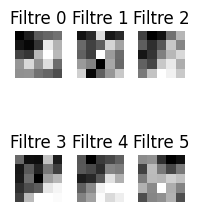

1ier Filtre/Canal de la 2e couche de convolution


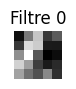

In [ ]:
print("Filtres/Canaux de la 1ière couche de convolution")
displayConvFilters(mnist_model, 'conv1', num_filter=6, filter_size=(5,5), num_channel=0, fig_size=(2,3))
print("1ier Filtre/Canal de la 2e couche de convolution")
displayConvFilters(mnist_model, 'conv2', num_filter=1, filter_size=(5,5), num_channel=0, fig_size=(1,1))